In [3]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Paths (Update these to your actual folders)
REAL_CT_PATH = r"C:\Users\Dines\OneDrive\Desktop\a\images\real"  # Folder containing 900 real images
FAKE_CT_PATH = r"C:\Users\Dines\OneDrive\Desktop\a\images\fake"  # Folder containing 900 fake images
OUTPUT_DIR = "processed_lung_ct_resnet50"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224  # Standard size for ResNet50 (224x224)
CHANNELS = 3    # Convert grayscale to 3-channel (if needed)

def load_images_from_folder(folder, max_images=900):
    """Loads and processes images from a given folder (limited to max_images)."""
    images = []
    filenames = os.listdir(folder)[:max_images]  # Limit to 900 images
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load as is
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to 3-channel RGB
            img = img / 255.0  # Normalize to [0,1]
            images.append(img)
    return np.array(images, dtype=np.float32)

# Load real and fake images (900 each)
real_images = load_images_from_folder(REAL_CT_PATH, max_images=900)
fake_images = load_images_from_folder(FAKE_CT_PATH, max_images=900)

# Create labels (0 = real, 1 = fake)
real_labels = np.zeros(len(real_images))
fake_labels = np.ones(len(fake_images))

# Combine and shuffle dataset
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)
X, y = shuffle(X, y, random_state=42)

# Train-validation-test split (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Save preprocessed data
np.save(os.path.join(OUTPUT_DIR, "X_train.npy"), X_train)
np.save(os.path.join(OUTPUT_DIR, "X_val.npy"), X_val)
np.save(os.path.join(OUTPUT_DIR, "X_test.npy"), X_test)
np.save(os.path.join(OUTPUT_DIR, "y_train.npy"), y_train)
np.save(os.path.join(OUTPUT_DIR, "y_val.npy"), y_val)
np.save(os.path.join(OUTPUT_DIR, "y_test.npy"), y_test)

# Print dataset sizes
print(f"✅ Preprocessing complete! Data saved in `{OUTPUT_DIR}`")
print(f"Real images: {len(real_images)} | Fake images: {len(fake_images)}")
print(f"Training set: {X_train.shape[0]} | Validation set: {X_val.shape[0]} | Testing set: {X_test.shape[0]}")


✅ Preprocessing complete! Data saved in `processed_lung_ct_resnet50`
Real images: 900 | Fake images: 900
Training set: 1440 | Validation set: 180 | Testing set: 180


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import os
import matplotlib.pyplot as plt

# ✅ Load preprocessed dataset
DATASET_DIR = "processed_lung_ct_resnet50"
X_train = np.load(os.path.join(DATASET_DIR, "X_train.npy"))
X_test = np.load(os.path.join(DATASET_DIR, "X_test.npy"))
y_train = np.load(os.path.join(DATASET_DIR, "y_train.npy"))
y_test = np.load(os.path.join(DATASET_DIR, "y_test.npy"))

# ✅ Load ResNet50 (Pretrained) as a feature extractor
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# ✅ Define model
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# ✅ Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_lung_ct_resnet50.h5", save_best_only=True, monitor='val_loss')

# ✅ Train model with callbacks
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=16, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

print("✅ Model training complete. Best model saved as best_lung_ct_resnet50.h5")


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7492 - loss: 0.9074  

90/90 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7497 - loss: 0.9053 - val_accuracy: 0.8111 - val_loss: 0.4656
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8835 - loss: 0.3908  

90/90 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8835 - loss: 0.3909 - val_accuracy: 0.8944 - val_loss: 0.3783
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9024 - loss: 0.3525 - val_accuracy: 0.8778 - val_loss: 0.4289
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9145 - loss: 0.2761  

90/90 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9145 - loss: 0.2762 - val_accuracy: 0.9111 - val_loss: 0.3388
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9516 - loss: 0.2295 - val_accuracy: 0.8833 - val_loss: 0.4096
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9725 - loss: 0.1923 - val_accuracy: 0.9167 - val_loss: 0.3671
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9568 - loss: 0.2159  

90/90 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9567 - loss: 0.2160 - val_accuracy: 0.9111 - val_loss: 0.3248
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9650 - loss: 0.1925 - val_accuracy: 0.9111 - val_loss: 0.3256
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9668 - loss: 0.1861 - val_accuracy: 0.9111 - val_loss: 0.4572
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9581 - loss: 0.1926 - val_accuracy: 0.9333 - val_loss: 0.3345
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9580 - loss: 0.2191  

90/90 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9580 - loss: 0.2190 - val_accuracy: 0.9222 - val_loss: 0.3246
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9623 - loss: 0.1900  

90/90 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9623 - loss: 0.1899 - val_accuracy: 0.9333 - val_loss: 0.3095
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9793 - loss: 0.1526  

90/90 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9793 - loss: 0.1526 - val_accuracy: 0.9222 - val_loss: 0.2857
Epoch 14/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9806 - loss: 0.1480 - val_accuracy: 0.9056 - val_loss: 0.3850
Epoch 15/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9767 - loss: 0.1670 - val_accuracy: 0.9056 - val_loss: 0.5330
Epoch 16/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9795 - loss: 0.1671 - val_accuracy: 0.9333 - val_loss: 0.3535
Epoch 17/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9479 - loss: 0.2124 - val_accuracy: 0.9000 - val_loss: 0.5281
Epoch 18/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9747 - loss: 0.1838 - val_accuracy: 0.9056 - val_loss: 0.4833
✅ Model training complete. Best model saved as best_lung_ct_resnet50.h5


In [1]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("best_lung_ct_resnet50.h5")

# Print model summary to confirm it's loaded
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100352)              │         401,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,679,747 (189.51 MB)

 Trainable params: 25,891,329 (98.77 MB)

 Non-trainable params: 23,788,416 (90.75 MB)

 Optimizer params: 2 (12.00 B)

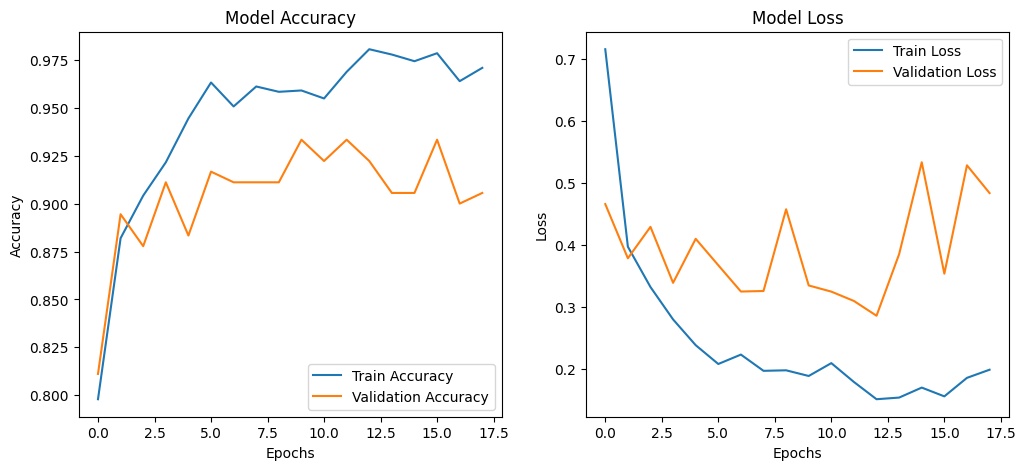

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
Classification Report:
               precision    recall  f1-score   support

        Real       0.90      0.94      0.92        90
        Fake       0.94      0.90      0.92        90

    accuracy                           0.92       180
   macro avg       0.92      0.92      0.92       180
weighted avg       0.92      0.92      0.92       180



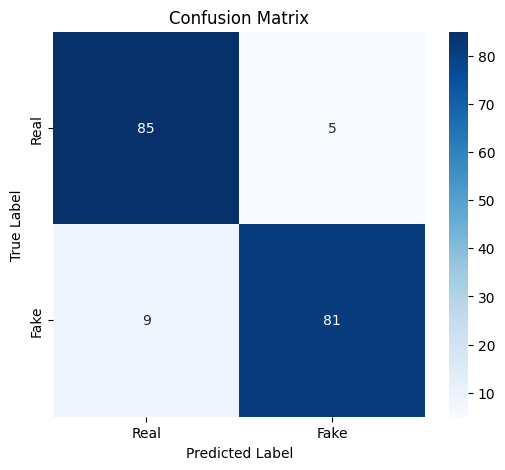

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get model predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [6]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
import os

# ✅ Load the trained ResNet50 model
MODEL_PATH = "best_lung_ct_resnet50.h5"  # Update to ResNet50 model path
model = load_model(MODEL_PATH, compile=False)

# ResNet50 expects 224x224x3 input
IMG_SIZE = 224
CHANNELS = 3

# ✅ Function to preprocess a single image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise ValueError(f"❌ Image not found: {image_path}")

    img = cv2.imread(image_path)  # Load image
    if img is None:
        raise ValueError(f"❌ Unable to load image: {image_path}")

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (ResNet50 expects RGB)
    img = preprocess_input(img)  # Apply ResNet50 preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# ✅ Function to make a prediction
def predict_image(image_path):
    try:
        img = preprocess_image(image_path)  # Preprocess input image
        prediction = model.predict(img)[0][0]  # Get prediction (single value)
        
        if prediction < 0.5:
            result = "✅ Real CT Scan (Class 0)"
        else:
            result = "❌ Fake CT Scan (Class 1)"
        
        print(f"Prediction: {prediction:.4f} --> {result}")
    except Exception as e:
        print(f"Error: {e}")

# ✅ Example usage
IMAGE_PATH = r"C:/Users/uppal/OneDrive/Desktop/a/r2.png"  # Change this to your test image path
predict_image(IMAGE_PATH)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: 0.0000 --> ✅ Real CT Scan (Class 0)
